<a href="https://colab.research.google.com/github/neharana404/Time-Series-Analysis-and-Forecasting/blob/main/Time_Series_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# Commented out IPython magic to ensure Python compatibility.
"""
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from scipy.io import arff


In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

"""
In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder.
You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

# Data
The [dataset]contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N)
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB)
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)
"""



"\nIn this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder.\nYou're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.\n\n# Data\nThe [dataset]contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.\n\n> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)\n\nWe have 5 types of hearbeats (classes):\n\n- Normal (N)\n- R-on-T Premature Ventricular Contraction (R-on-T PVC)\n- Premature Ventricular Contraction (PVC)\n- Supra-ventricular Premature or Ectopic Beat (SP or EB)\n

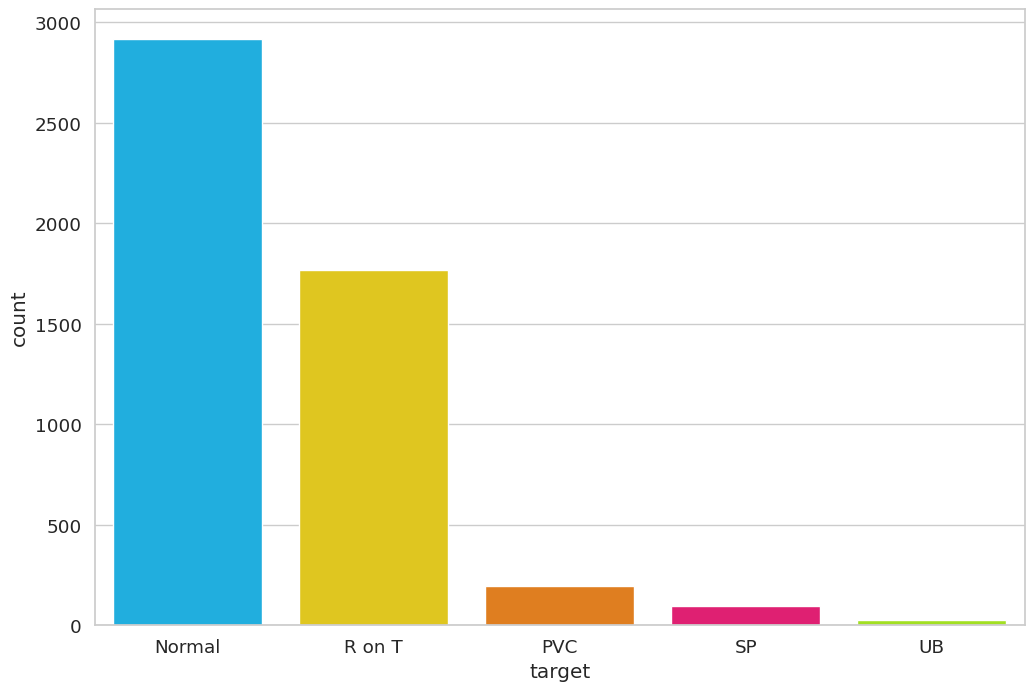

In [ ]:
#Load the arff files into Pandas data frames
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#with open(r'C:\Users\aanand5\Documents\TimeSeriesAnalysis_Spring2019\Fall_2022\LSTM_AutoEncoders\ECG5000_TRAIN.arff') as f:

data1 = arff.loadarff(r'ECG5000_TRAIN.arff')
train = pd.DataFrame(data1[0])
train["target"] = train['target'].str.decode("utf-8")
train.head()


#with open(r'C:\Users\aanand5\Documents\TimeSeriesAnalysis_Spring2019\Fall_2022\LSTM_AutoEncoders\ECG5000_TEST.arff') as f:
data1 = arff.loadarff(r'ECG5000_TEST.arff')
test = pd.DataFrame(data1[0])
test["target"] = test['target'].str.decode("utf-8")
test.head()

#We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:"""

#df = train.append(test)
df = pd.concat([train,test])

df = df.sample(frac=1.0)
df.shape

df.head()

"""We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:"""

CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

#"""Next, we'll rename the last column to `target`, so its easier to reference it:"""

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

# """## Exploratory Data Analysis

# Let's check how many examples for each heartbeat class do we have:
# """

df.target.value_counts()

#ax = sns.countplot(df.target);

ax = sns.countplot(x="target", data=df,order = df['target'].value_counts().index);
ax.set_xticklabels(class_names);

#"""The normal class, has by far, the most examples.

#Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:
#"""



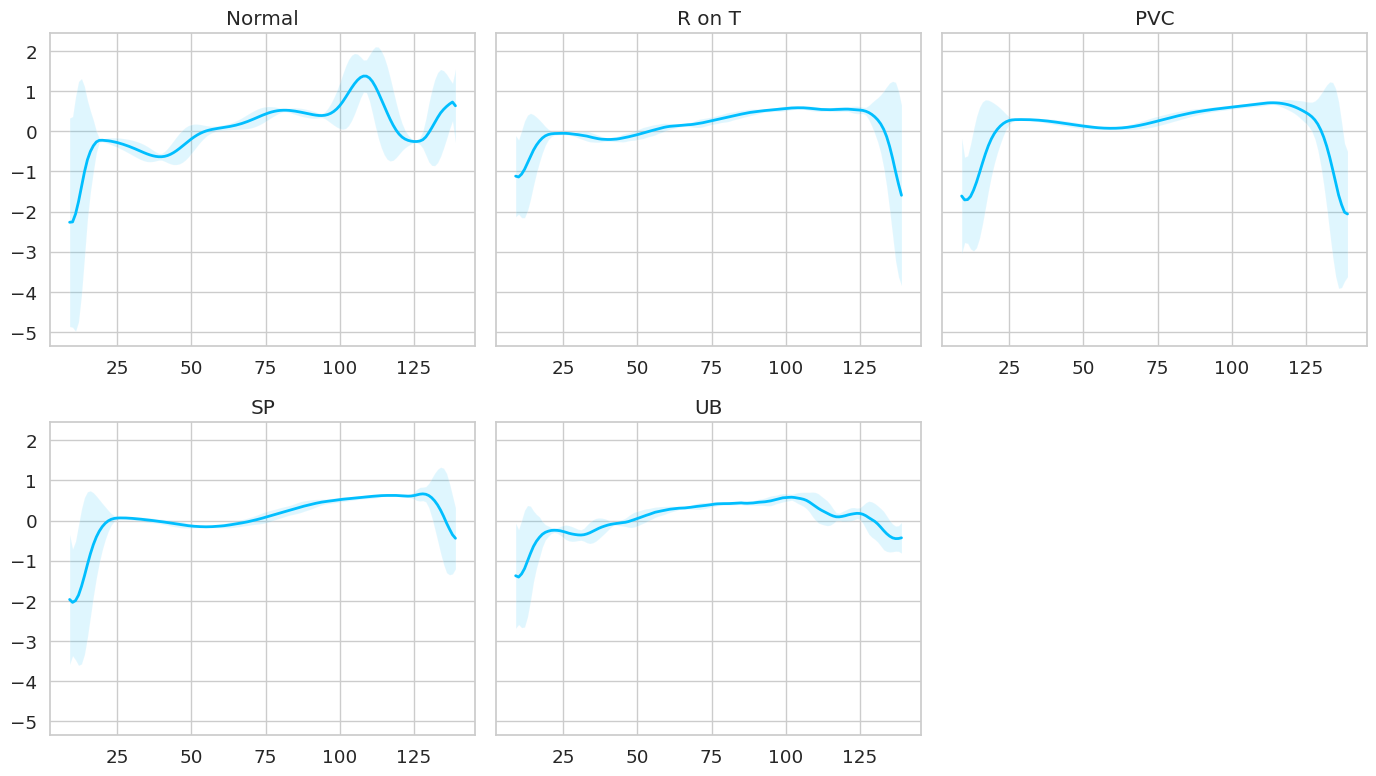

In [ ]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

## LSTM Autoencoder

### Data Preprocessing

#Let's get all normal heartbeats and drop the target (class) column:

normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

#Merge all other classes and mark them as anomalies:"""

anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

#Split the normal examples into train, validation and test sets:"""

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)


In [ ]:
#Convert our examples into tensors, so we can use them to train our Autoencoder.

def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

#Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

#Create Train, Val and Test datasets:

train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

# LSTM Autoencoder
#The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    #self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.embedding_dim, self.hidden_dim = embedding_dim, embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    #x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn1(x)
    #x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

"""The *Encoder* uses LSTM layers to compress the Time Series data input.
Next, we'll decode the compressed representation using a *Decoder*:
"""

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    # self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.hidden_dim, self.n_features = input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    # self.rnn2 = nn.LSTM(
    #   input_size=input_dim,
    #   hidden_size=self.hidden_dim,
    #   num_layers=1,
    #   batch_first=True
    # )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    #x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
training_loss_final = []
validation_loss_final = []
normal_det = []
anamoly_det = []

Epoch 1: train loss 93.4181704353969 val loss 87.36161991679221
Epoch 2: train loss 72.1349528050144 val loss 69.22690741112615
Epoch 3: train loss 69.26852772630832 val loss 68.94119282224479
Epoch 4: train loss 68.24863617269322 val loss 68.76230254189554
Epoch 5: train loss 67.8100722058076 val loss 68.97316649505302
Epoch 6: train loss 67.5848884259631 val loss 68.85329290136136
Epoch 7: train loss 67.38276791832035 val loss 69.36631048417335
Epoch 8: train loss 67.20173619034694 val loss 69.43264734053368
Epoch 9: train loss 67.07761024496624 val loss 68.77903739746927
Epoch 10: train loss 66.97943557284138 val loss 68.6626514656145
Epoch 11: train loss 66.87859058649201 val loss 68.11818210745021
Epoch 12: train loss 66.81630945878373 val loss 67.78903596637193
Epoch 13: train loss 66.70196265051895 val loss 67.20063141181608
Epoch 14: train loss 66.58913798334136 val loss 65.99311457559111
Epoch 15: train loss 66.53622003391547 val loss 65.79054869563913
Epoch 16: train loss 66.

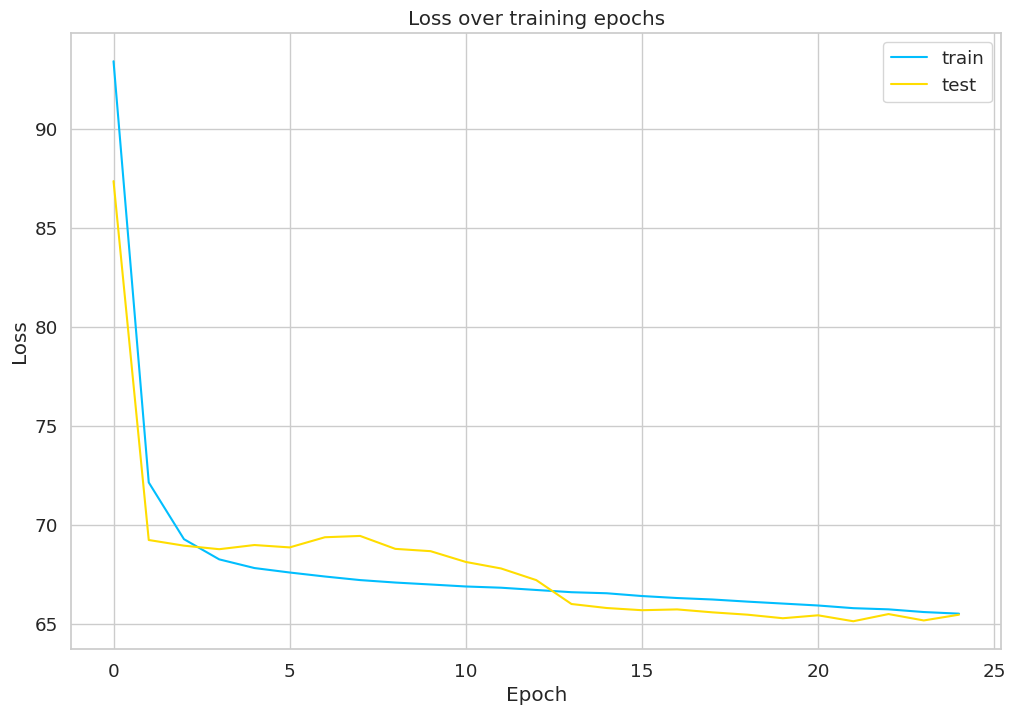

<ipython-input-16-af6747406ca3>:127: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);
<ipython-input-16-af6747406ca3>:144: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


Correct normal predictions: 2/145


<ipython-input-16-af6747406ca3>:161: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


Correct anomaly predictions: 144/145
0.993103448275862
Training Loss: [65.5054870061171]
Validation Loss: [65.45292647950885]
Normal:  [0.993103448275862]
Anomly:  [0.993103448275862]
Epoch 1: train loss 78.21902477044533 val loss 72.76182164267061
Epoch 2: train loss 69.31747879188227 val loss 70.23570389470956
Epoch 3: train loss 68.7661690886873 val loss 69.38325527829114
Epoch 4: train loss 68.11354097845285 val loss 68.89458173940614
Epoch 5: train loss 67.51529357799451 val loss 68.82950705310184
Epoch 6: train loss 66.28662256981183 val loss 66.47249454849816
Epoch 7: train loss 64.84137875742607 val loss 62.76687835589204
Epoch 8: train loss 61.72608451428119 val loss 59.525135587099875
Epoch 9: train loss 58.61237536010988 val loss 57.402049692824434
Epoch 10: train loss 55.83795902739605 val loss 55.99020659150524
Epoch 11: train loss 53.76379191188359 val loss 53.85585619565163
Epoch 12: train loss 52.25818523789836 val loss 51.998138505851045
Epoch 13: train loss 51.2320775

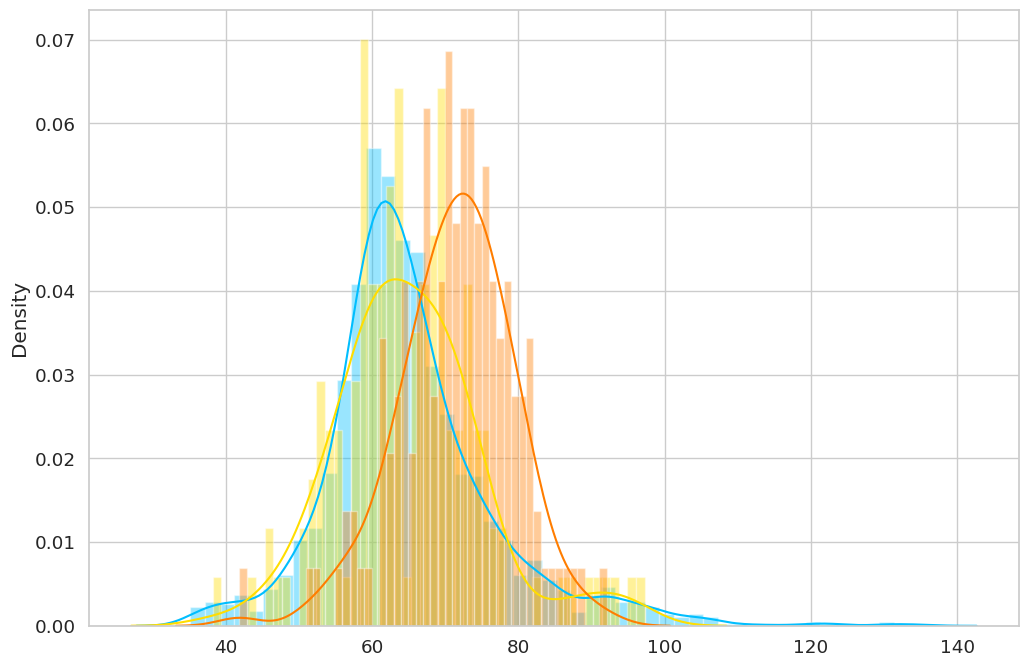

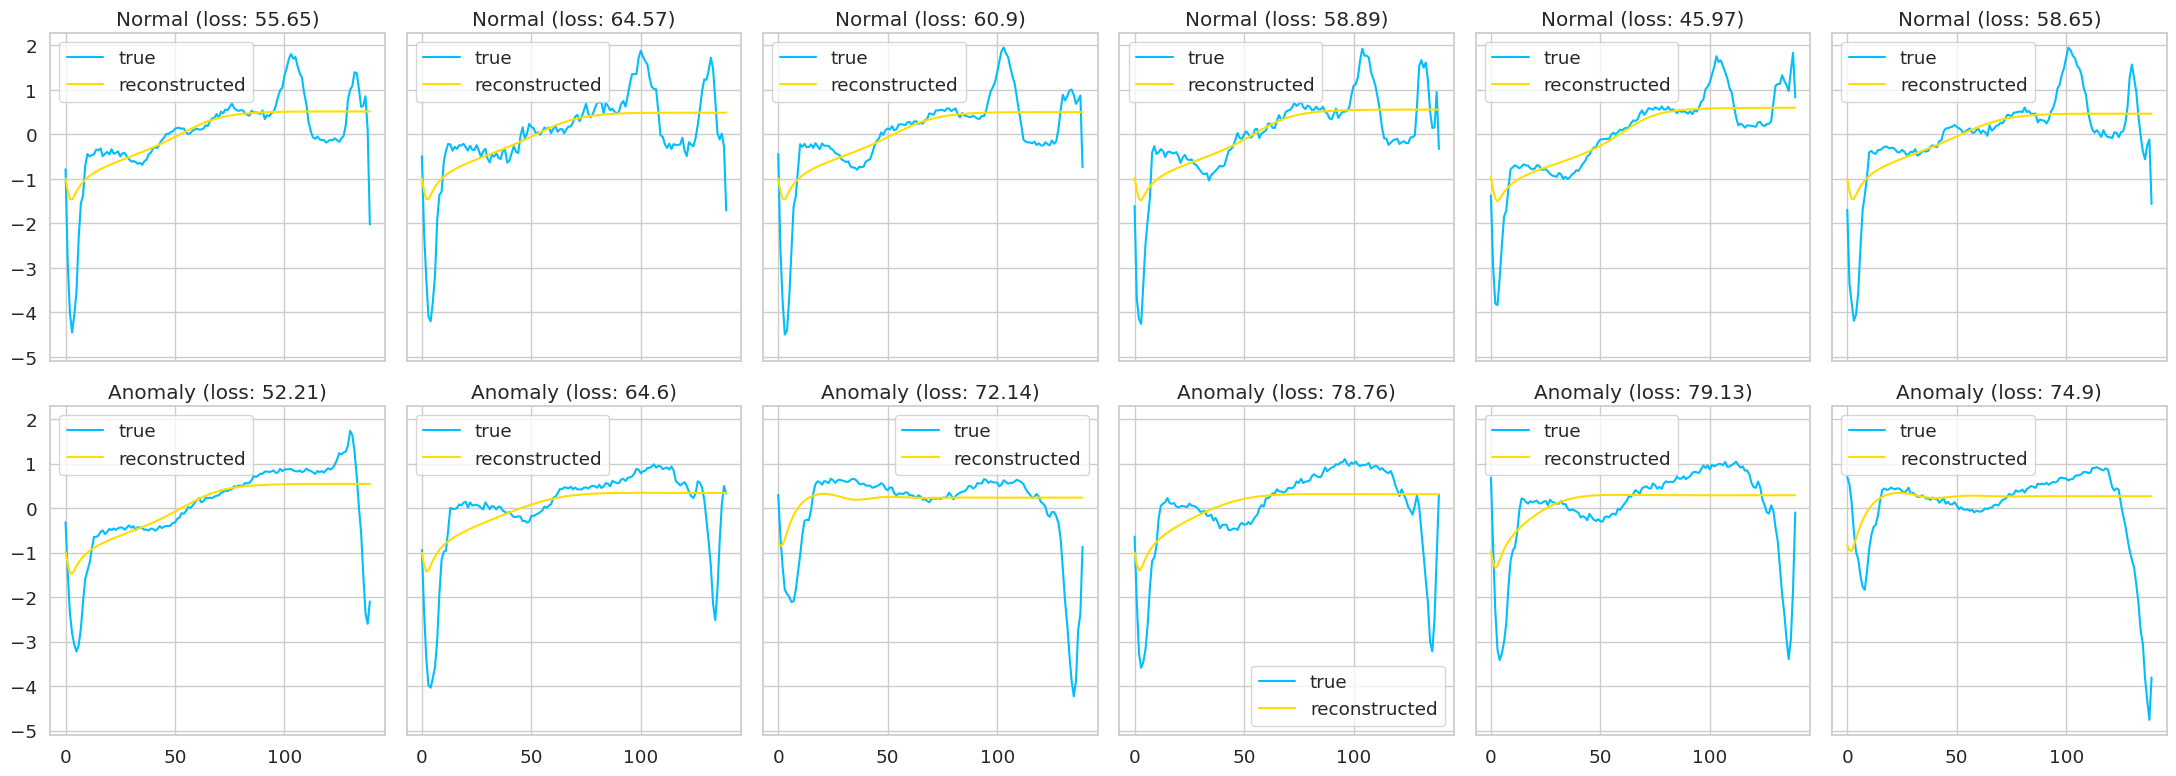

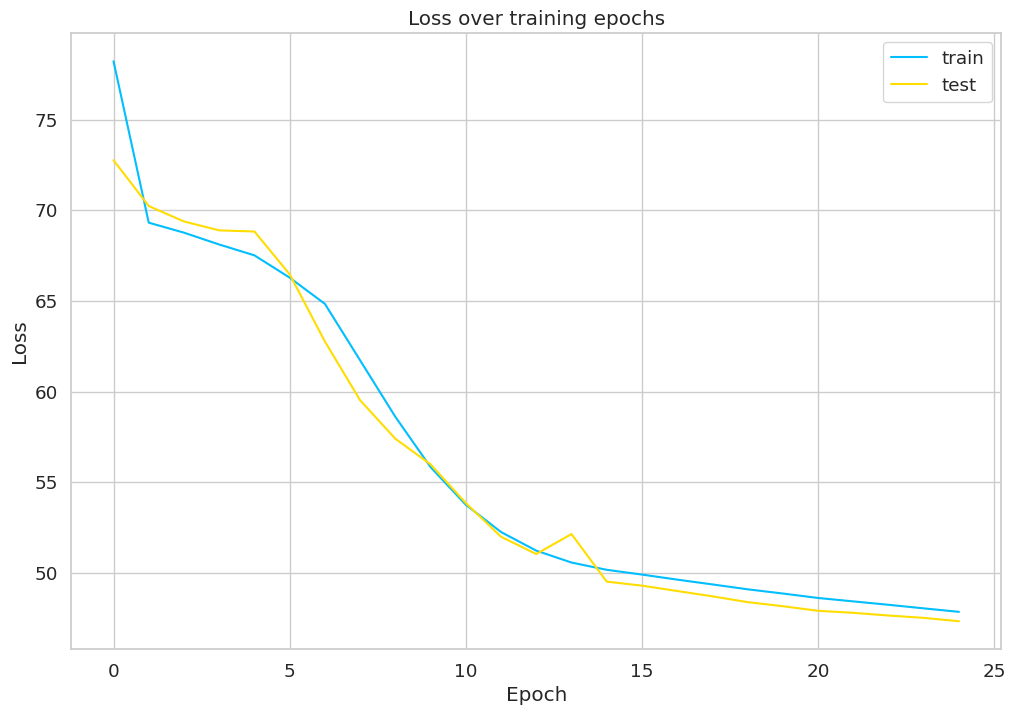

<ipython-input-16-af6747406ca3>:127: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);
<ipython-input-16-af6747406ca3>:144: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


Correct normal predictions: 58/145


<ipython-input-16-af6747406ca3>:161: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


Correct anomaly predictions: 143/145
0.9862068965517241
Training Loss: [65.5054870061171, 47.85611461853126]
Validation Loss: [65.45292647950885, 47.33810618794412]
Normal:  [0.993103448275862, 0.9862068965517241]
Anomly:  [0.993103448275862, 0.9862068965517241]
Epoch 1: train loss 76.40337974705172 val loss 69.06797274957339
Epoch 2: train loss 68.69252332589743 val loss 67.59507090077058
Epoch 3: train loss 65.59876028427622 val loss 63.12481069727562
Epoch 4: train loss 61.39005291534018 val loss 58.487815739758595
Epoch 5: train loss 55.04963044070852 val loss 52.75610768184727
Epoch 6: train loss 51.900908188395135 val loss 51.25377382922905
Epoch 7: train loss 50.98300093405192 val loss 50.350096783947215
Epoch 8: train loss 50.54618264167168 val loss 49.96820286435072
Epoch 9: train loss 50.163199922530126 val loss 49.587263309101196
Epoch 10: train loss 49.85328036534695 val loss 49.32540909178021
Epoch 11: train loss 49.53507253961283 val loss 48.96300771537494
Epoch 12: train

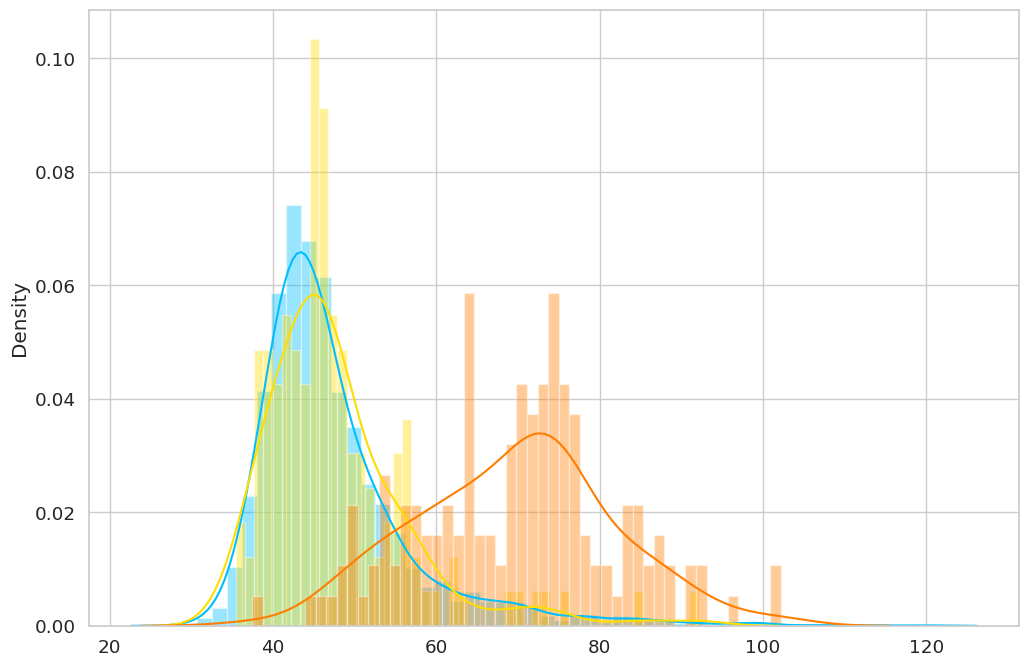

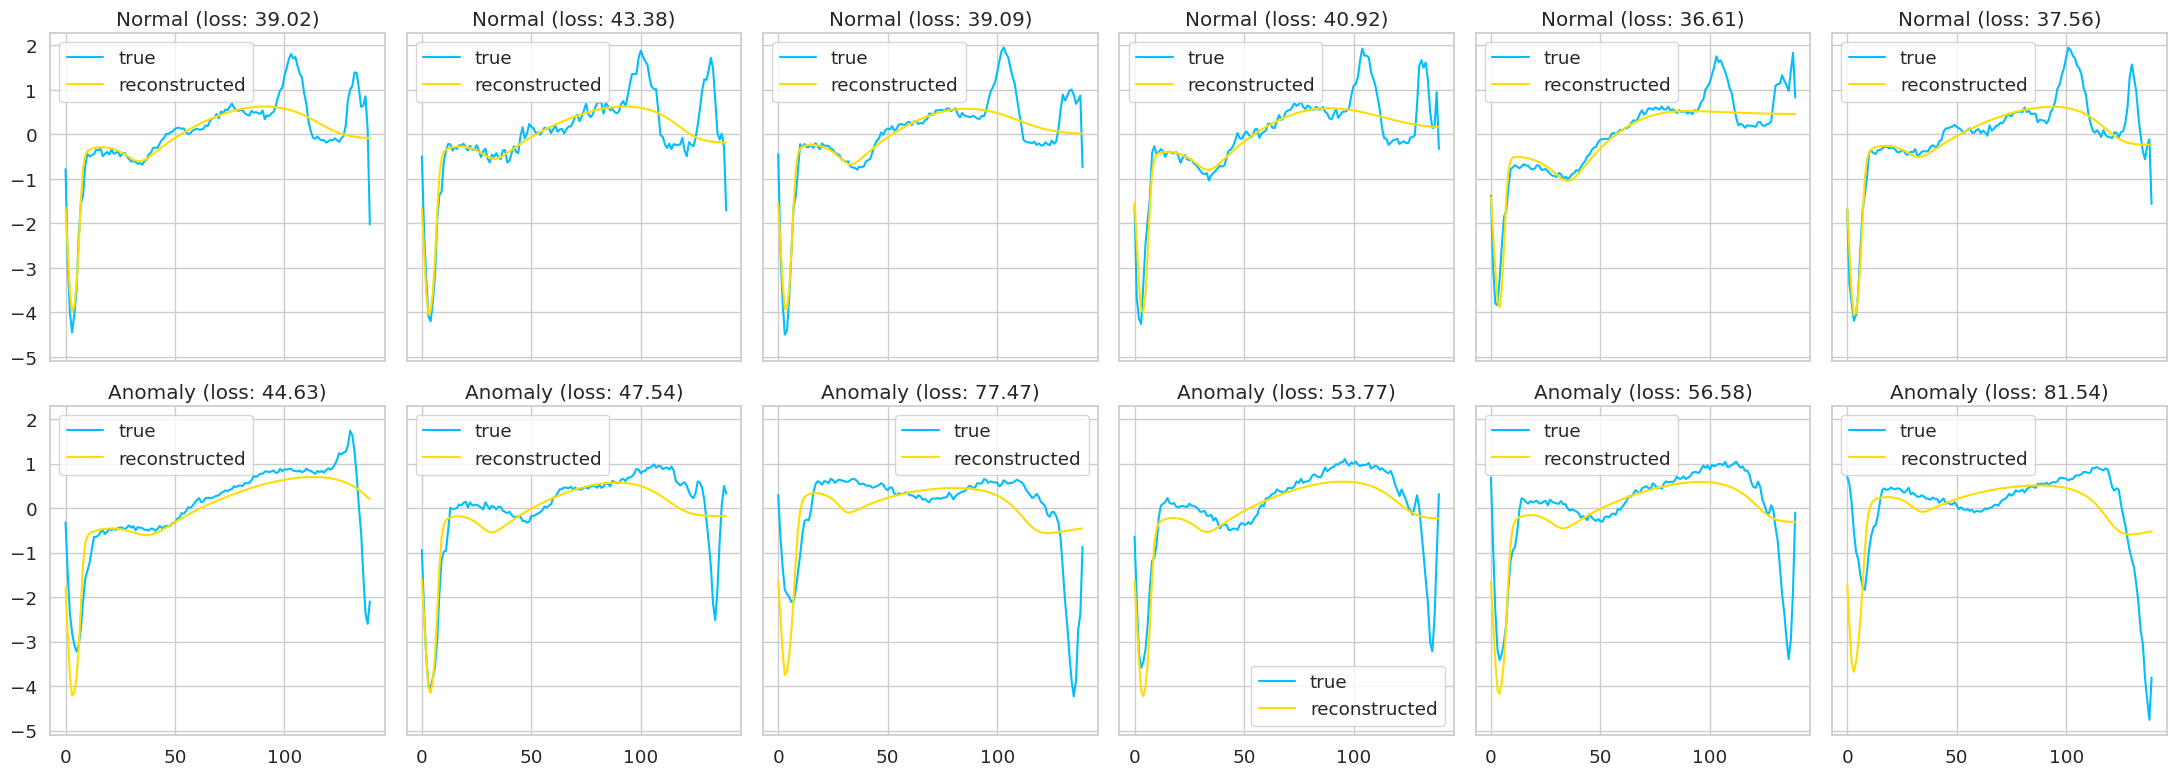

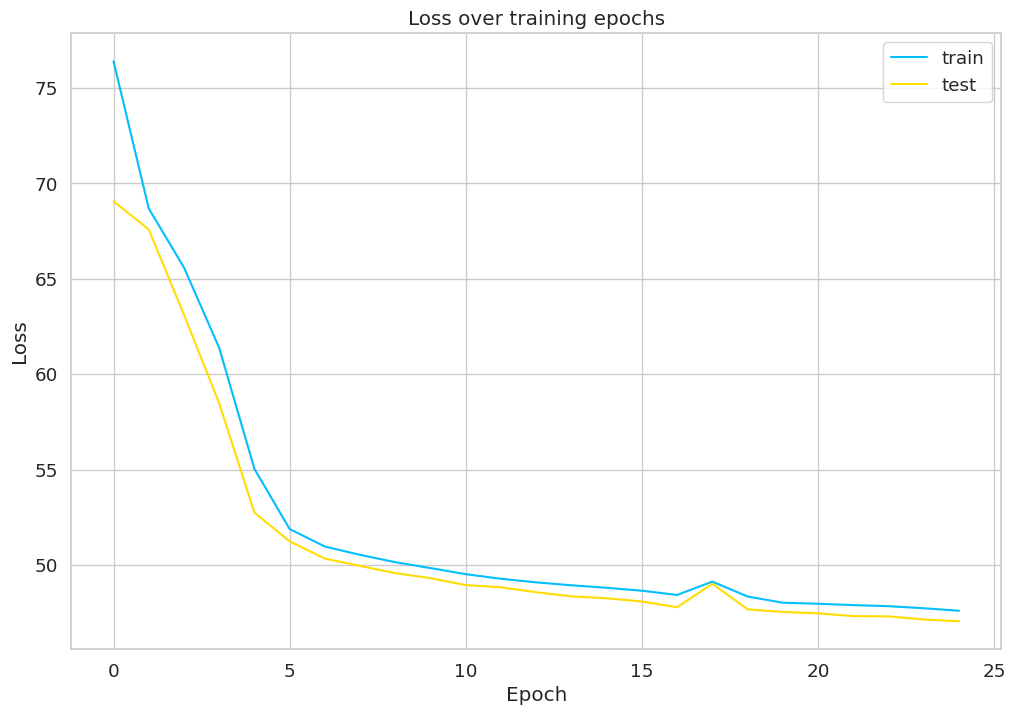

<ipython-input-16-af6747406ca3>:127: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);
<ipython-input-16-af6747406ca3>:144: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


Correct normal predictions: 60/145


<ipython-input-16-af6747406ca3>:161: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


Correct anomaly predictions: 142/145
0.9793103448275862
Training Loss: [65.5054870061171, 47.85611461853126, 47.61910753892055]
Validation Loss: [65.45292647950885, 47.33810618794412, 47.068828960327565]
Normal:  [0.993103448275862, 0.9862068965517241, 0.9793103448275862]
Anomly:  [0.993103448275862, 0.9862068965517241, 0.9793103448275862]
Epoch 1: train loss 73.18570793948314 val loss 61.6509106736948
Epoch 2: train loss 57.44842985722866 val loss 53.65881451811807
Epoch 3: train loss 53.16222638518808 val loss 52.031405478207326
Epoch 4: train loss 51.73094780586363 val loss 51.01265888409403
Epoch 5: train loss 50.96268482584955 val loss 49.73574888991008
Epoch 6: train loss 50.25153909042832 val loss 49.21757207876993
Epoch 7: train loss 49.89382664804639 val loss 48.845902804221716
Epoch 8: train loss 49.54783189397625 val loss 48.41021460315066
Epoch 9: train loss 48.77717876472765 val loss 48.29250603893918
Epoch 10: train loss 48.32263154456905 val loss 48.082483233038474
Epoch

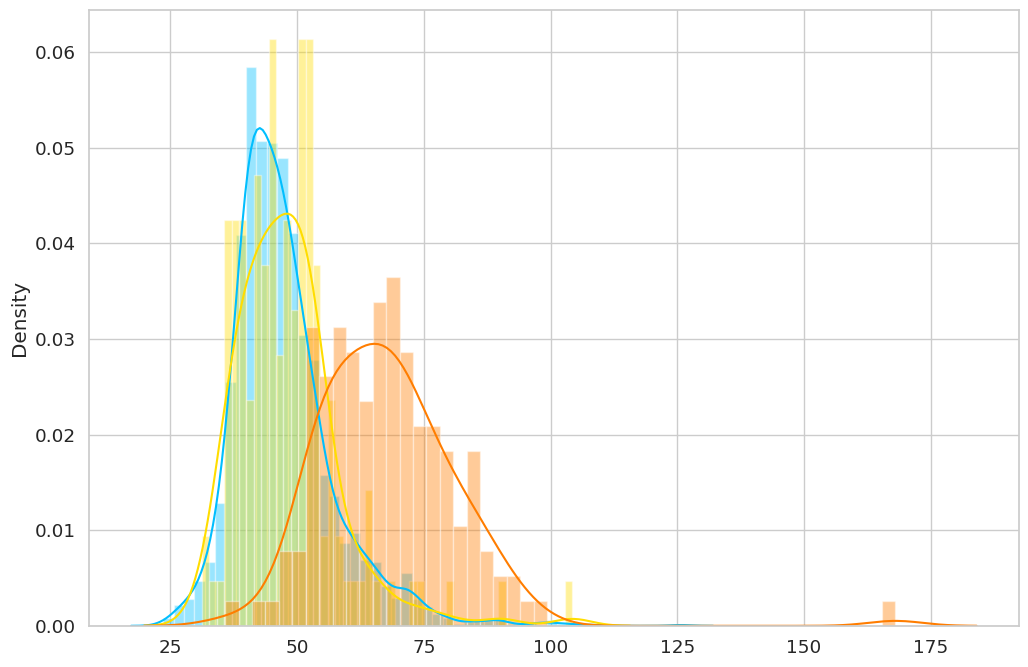

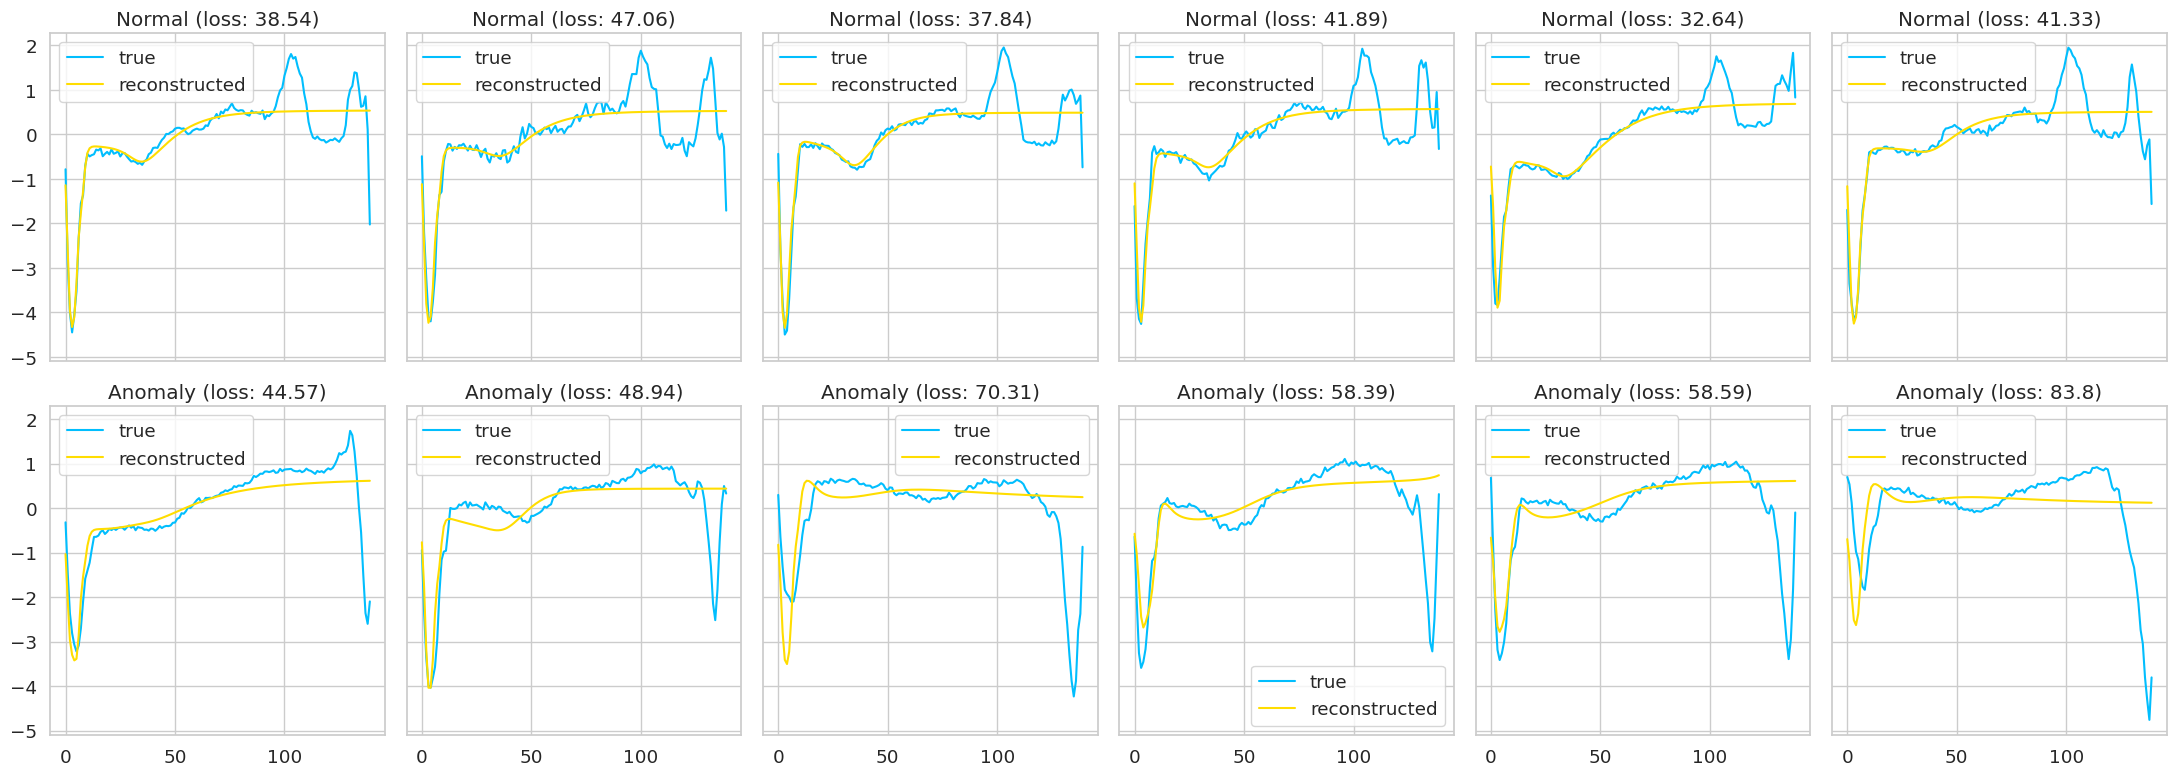

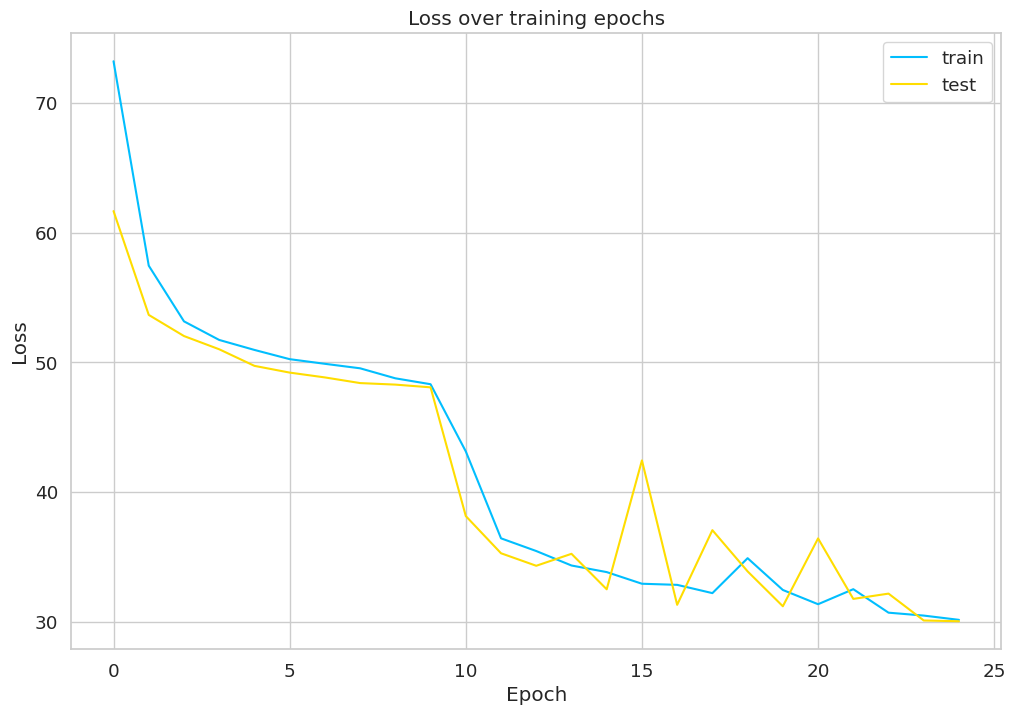

<ipython-input-16-af6747406ca3>:127: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);
<ipython-input-16-af6747406ca3>:144: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


Correct normal predictions: 131/145


<ipython-input-16-af6747406ca3>:161: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


Correct anomaly predictions: 143/145
0.9862068965517241
Training Loss: [65.5054870061171, 47.85611461853126, 47.61910753892055, 30.18270740255335]
Validation Loss: [65.45292647950885, 47.33810618794412, 47.068828960327565, 30.075288053258696]
Normal:  [0.993103448275862, 0.9862068965517241, 0.9793103448275862, 0.9862068965517241]
Anomly:  [0.993103448275862, 0.9862068965517241, 0.9793103448275862, 0.9862068965517241]
Training Loss: [65.5054870061171, 47.85611461853126, 47.61910753892055, 30.18270740255335]
Validation Loss: [65.45292647950885, 47.33810618794412, 47.068828960327565, 30.075288053258696]
Normal:  [0.993103448275862, 0.9862068965517241, 0.9793103448275862, 0.9862068965517241]
Anomly:  [0.993103448275862, 0.9862068965517241, 0.9793103448275862, 0.9862068965517241]


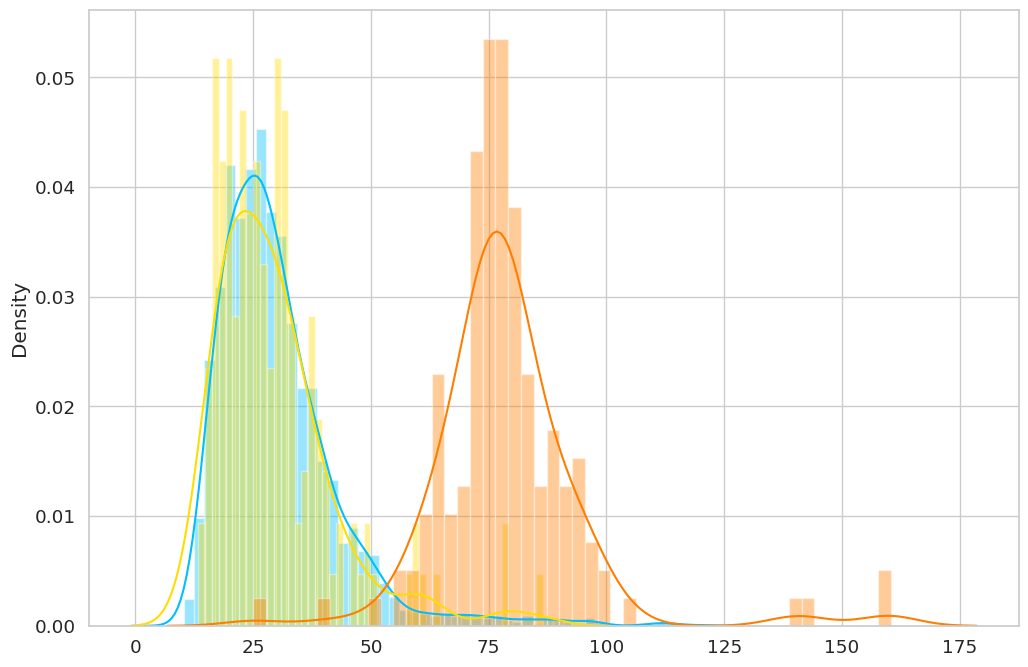

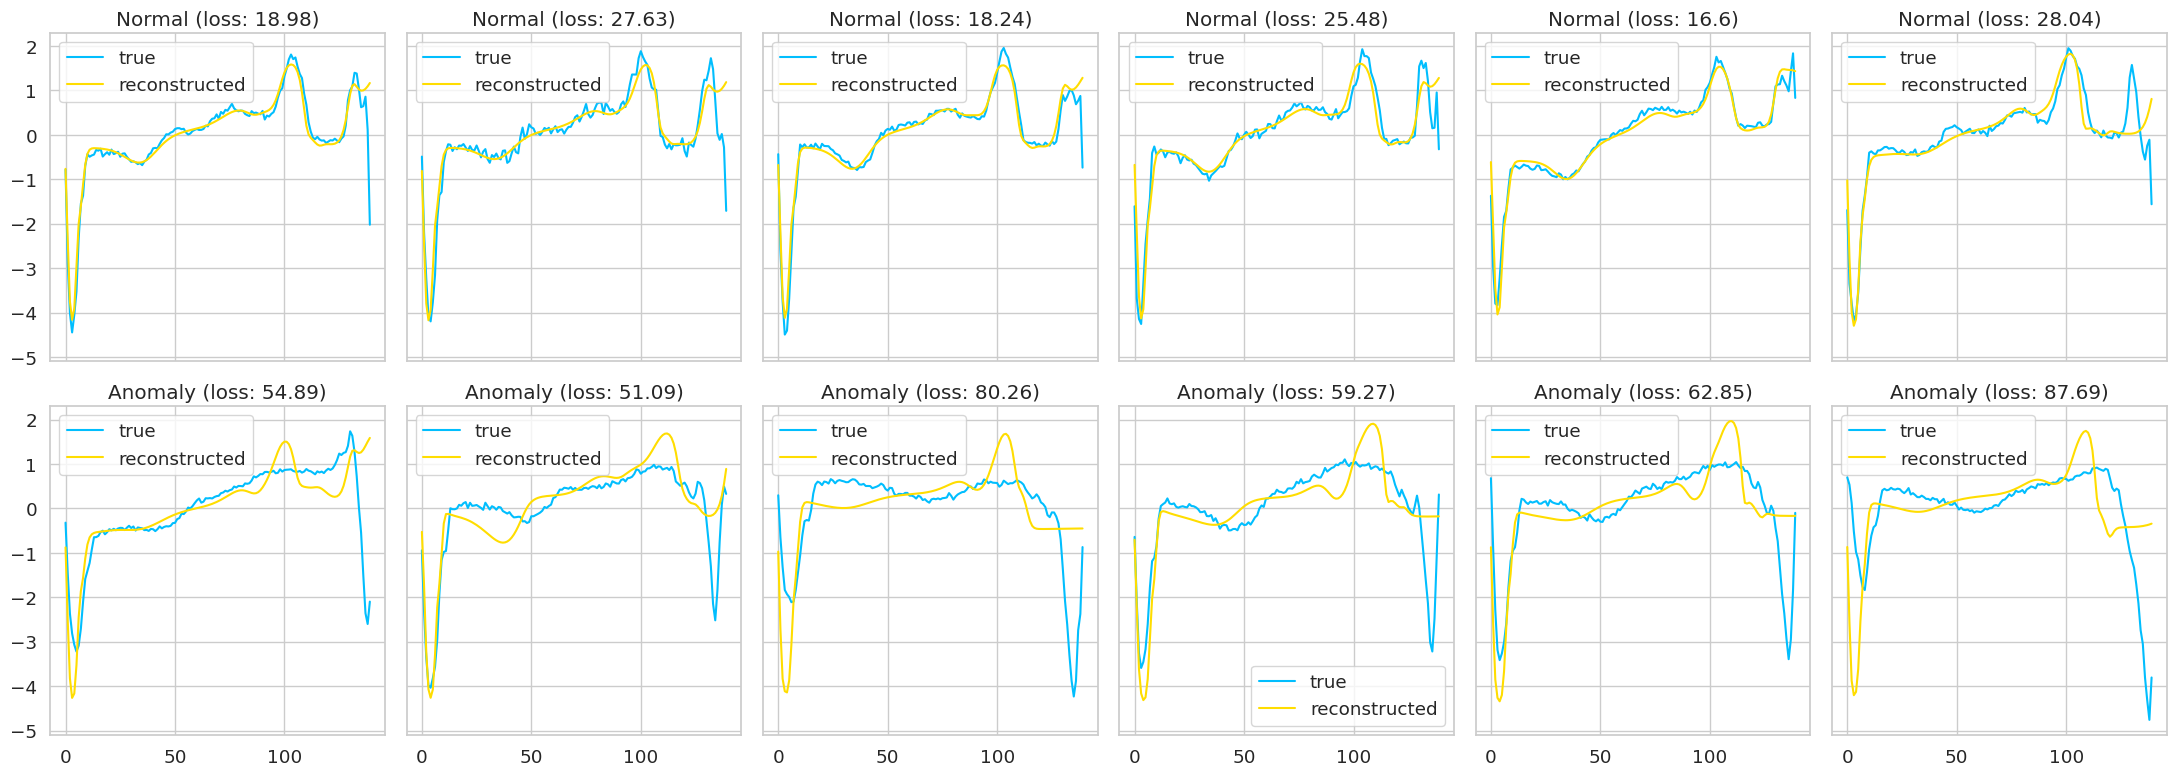

In [ ]:
"""Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:"""

embeddings = [2,4,6,8]

for embedding_dimension in embeddings:
  training_loss = []
  validation_loss = []
  model = RecurrentAutoencoder(seq_len, n_features, embedding_dimension)
  model = model.to(device)

  """## Training

  Let's write a helper function for our training process:
  """

  def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, n_epochs + 1):
      model = model.train()

      train_losses = []
      for seq_true in train_dataset:
        optimizer.zero_grad()

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

      val_losses = []
      model = model.eval()
      with torch.no_grad():
        for seq_true in val_dataset:

          seq_true = seq_true.to(device)
          seq_pred = model(seq_true)

          loss = criterion(seq_pred, seq_true)
          val_losses.append(loss.item())

      train_loss = np.mean(train_losses)
      val_loss = np.mean(val_losses)

      history['train'].append(train_loss)
      history['val'].append(val_loss)

      if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

      print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
      training_loss.append(train_loss)
      validation_loss.append(val_loss)
    model.load_state_dict(best_model_wts)
    return model.eval(), history


  """At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

  Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

  We'll get the version of the model with the smallest validation error. Let's do some training:
  """

  model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=25
  )


  ax = plt.figure().gca()

  ax.plot(history['train'])
  ax.plot(history['val'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'])
  plt.title('Loss over training epochs')
  plt.show();

  ## Saving the model

  #Let's store the model for later use:


  MODEL_PATH = 'model.pth'

  torch.save(model, MODEL_PATH)

  """## Choosing a threshold

  With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:
  """

  def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
      model = model.eval()
      for seq_true in dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)

        predictions.append(seq_pred.cpu().numpy().flatten())
        losses.append(loss.item())
    return predictions, losses

  """Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:"""

  _, losses = predict(model, train_dataset)

  sns.distplot(losses, bins=50, kde=True);

  THRESHOLD = 45

  """## Evaluation

  Using the threshold, we can turn the problem into a simple binary classification task:

  - If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
  - Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

  ### Normal hearbeats

  Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):
  """

  predictions, pred_losses = predict(model, test_normal_dataset)
  sns.distplot(pred_losses, bins=50, kde=True);

  """We'll count the correct predictions:"""

  correct = sum(l <= THRESHOLD for l in pred_losses)
  print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

  """### Anomalies

  We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:
  """

  anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
  #anomaly_dataset = test_anomaly_dataset
  """Now we can take the predictions of our model for the subset of anomalies:"""

  predictions, pred_losses = predict(model, anomaly_dataset)
  sns.distplot(pred_losses, bins=50, kde=True);

  """Finally, we can count the number of examples above the threshold (considered as anomalies):"""

  correct = sum(l > THRESHOLD for l in pred_losses)
  print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

  print(correct/len(test_normal_dataset))
  #### Looking at Examples

  #We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

  def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

  fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharey=True,
    sharex=True,
    figsize=(22, 8)
  )

  for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

  for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

  fig.tight_layout();

  training_loss_final.append(training_loss[-1])
  validation_loss_final.append(validation_loss[-1])
  normal_det.append(correct/len(test_normal_dataset))
  anamoly_det.append(correct/len(anomaly_dataset))

  print('Training Loss:' , training_loss_final)
  print('Validation Loss:', validation_loss_final)
  print('Normal: ',  normal_det)
  print('Anomly: ',  anamoly_det)

print('Training Loss:' , training_loss_final)
print('Validation Loss:', validation_loss_final)
print('Normal: ',  normal_det)
print('Anomly: ',  anamoly_det)
  # print('Anomly:', anamoly_det)

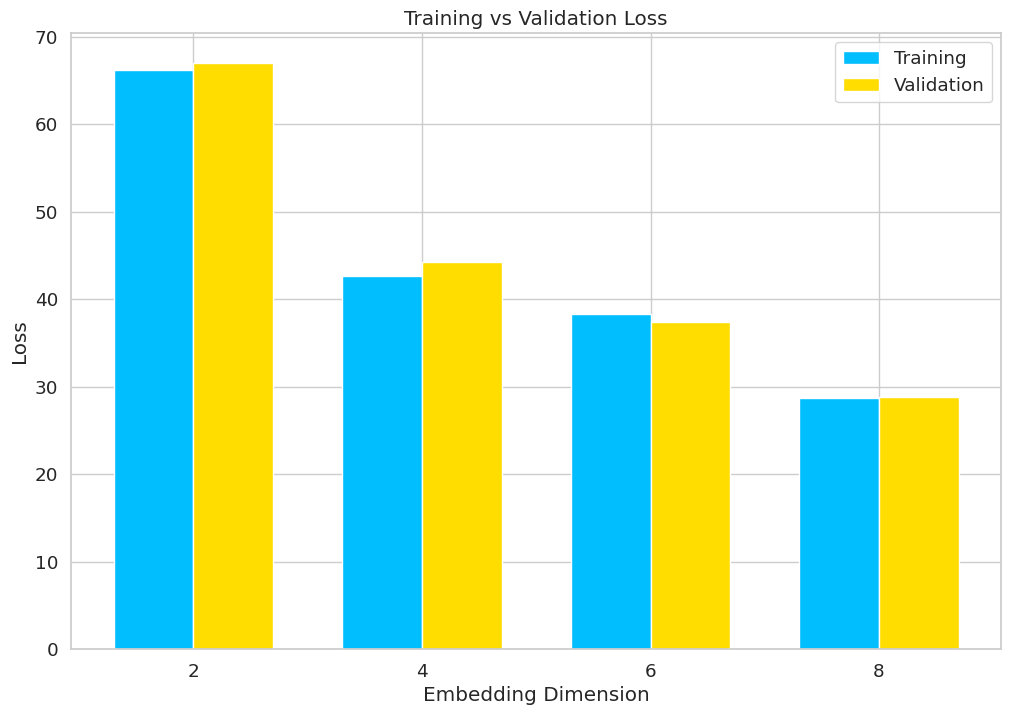

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

training_loss_num = [66.27329042427773, 42.68845198991461, 38.37665700931695, 28.749965211452373]
validati_loss_num = [67.06545542694197, 44.294250332047916, 37.40398922552428, 28.84862243600266]

bar_width = 0.35

# Create an index for each group, so they are spaced properly
index = np.arange(len(training_loss_num))

# Create the bar plots
plt.bar(index, training_loss_num, bar_width, label='Training')
plt.bar(index + bar_width, validati_loss_num, bar_width, label='Validation')

# Customize the plot
plt.xlabel('Embedding Dimension')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.xticks(index + bar_width / 2, ['2', '4', '6', '8'])
plt.legend()

# Show the plot
plt.show()



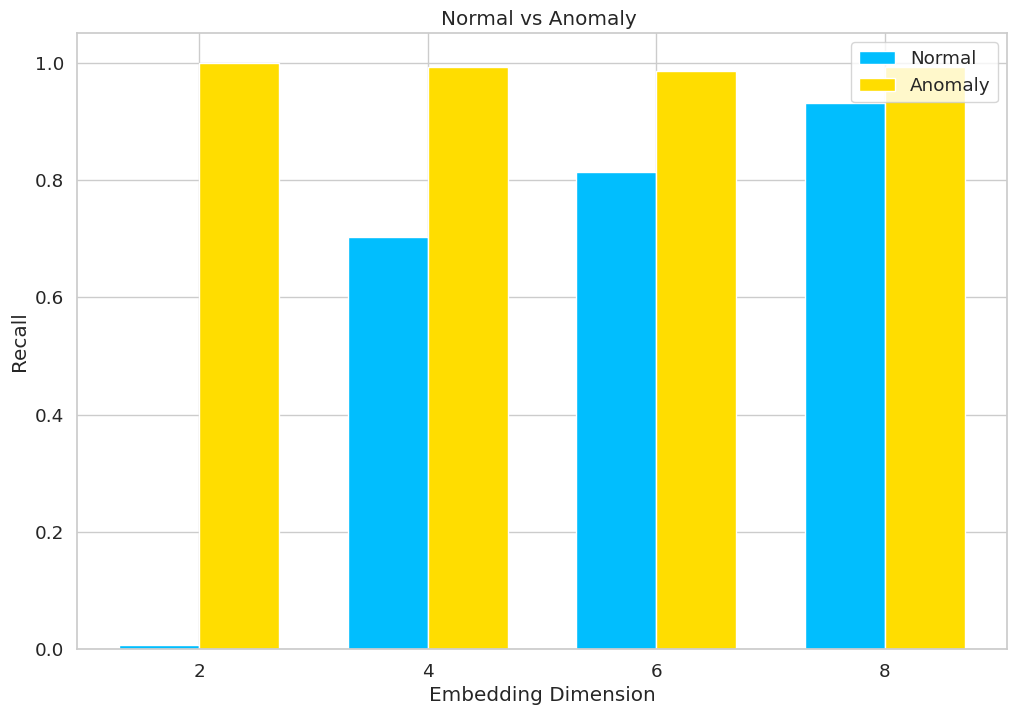

In [ ]:

normal_num = [0.00689655172, 0.70344827586, 0.81379310344, 0.93103448275]
anomaly_num = [1, 0.99310344827, 0.98620689655, 0.99310344827]

bar_width = 0.35

# Create an index for each group, so they are spaced properly
index = np.arange(len(normal_num))

# Create the bar plots
plt.bar(index, normal_num, bar_width, label='Normal')
plt.bar(index + bar_width, anomaly_num, bar_width, label='Anomaly')

# Customize the plot
plt.xlabel('Embedding Dimension')
plt.ylabel('Recall')
plt.title('Normal vs Anomaly ')
plt.xticks(index + bar_width / 2, ['2', '4', '6', '8'])
plt.legend()

# Show the plot
plt.show()